## Understanding Flair Dataset
This notebook tries provides details on the structure of the flair dataset and makes suggestions how to process the data.

## The FLAIR study

**Title**: A Crossover Study Comparing Two Automated Insulin Delivery System
Algorithms (PID vs. PID + Fuzzy Logic) in Individuals with Type 1
Diabetes (FLAIR- Fuzzy Logic Automated Insulin Regulation)

**Description**: A randomized crossover trial will compare the efficacy and safety of an
automated insulin delivery (AID) system with a proportional-integral-
derivative (PID) algorithm versus an automatic insulin delivery (AID) system
with a PID algorithm enhanced with a Fuzzy Logic algorithm.
    
**Devices**: The Minimed 670G 4.0 Advanced Hybrid Closed-Loop (AHCL) (PID +
Fuzzy Logic) pump with the Guardian Sensor (3) continuous glucose
monitoring sensor.

# Data
The study data folder is named **FLAIRPublicDataSet**
From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **FLAIRDeviceCGM.txt**: List of CGM data downloaded
* **FLAIRDevicePump.txt**: List of pump data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Medtronic pump events and the guardian cgm. The glossary provides information about each column. While there are many columns, the following were identified as relevant.

## FLAIRDeviceCGM
* **PtID**: Patient ID
* **DataDtTm**: Date-time of sensor glucose reading
* **CGM**: Sensor glucose aka CGM - mdDl or mmol/L
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 

## FLAIRDevicePump
* **PtID**: Patient ID
### Time-Related
* **DataDtTm**: Date-time of pump data
* **NewDeviceDtTm**: The new date and time if this was changed in the device

### Bolus related
* **BolusType**: Bolus type - The bolus insulin delivery type [Normal, Square, Dual (normal part), or Dual (square part)]
* **BolusDeliv**: Bolus volume delivered (U) - The number of insulin units actually delivered during the bolus insulin delivery
* **ExtendBolusDuration**: Duration of the square portion of either a square bolus or a dual wave bolus

### Basal Related
* **BasalRt**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
* **BasalRtUnKnown**: Basal rate unknown as marked in the carelink file
* **TempBasalAmt**: Temp basal amount - If a temp basal was applied on the pump, this value is the temp basal amount
* **TempBasalType**: Temp basal type - The type of temporary basal adjustment (insulin rate or percent of basal)
* **TempBasalDur**: Temp basal duration (h:mm:ss) - The length of time for the temporary basal insulin delivery

### Other
Suspend: State "Suspend" when the pump is suspended and "Resumed" when the pump is resumed 

## Questions
* Do we need to track DataDtTm_adjusted or can we rely on DataDtTm?
* How often do NewDeviceDtTm** events happen and do we need to account fo these or is DataDtTm sufficient?
* How often do BasalRtUnKnown** events happen and how should we handle these?
* Are TempBasalAmt reflected in the BasalRt? Is the value a rate (U/h) or depend on the TempBasalType (Percent/Rate)?
* Do we have to keep track of temporary basal durations events (TempBasalDur) or do we get a normal basal rate at the end of the basal rate?
* How often does the pump suspend (Suspend)? Should we stop counting basal rates in this time?



In [161]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

## Load the data

In [2]:
def parse_flair_dates(df, date_column):
    """Parse date strings separately for those with/without time component, interpret those without as midnight (00AM)
        Args:
            df (pandas DataFrame): data frame holding data
            date_column (string): column name that holds date time strings to be used for parsing

        Returns:
            df (pandas DataFrame): with new DateTime column holding datetime objects
        """
    #
    b_only_date = (df[date_column].str.len() <= 10)
    print(sum(b_only_date))
    df.loc[b_only_date, 'DateTime'] = pd.to_datetime(df.loc[b_only_date, date_column], format='%m/%d/%Y')
    df.loc[~b_only_date, 'DateTime'] = pd.to_datetime(df.loc[~b_only_date, date_column], format='%m/%d/%Y %I:%M:%S %p')
    return df

## inspecting the event counts

In [16]:
current_dir = os.getcwd(); 
path = os.path.join(current_dir, '..', '..', 'data/raw','FLAIRPublicDataSet','Data Tables', 'FLAIRDeviceCGM.txt')
df_cgm = pd.read_csv(path, sep="|", low_memory=False, usecols=['PtID', 'DataDtTm', 'CGM', 'DataDtTm_adjusted'])
df_cgm = parse_flair_dates(df_cgm,'DataDtTm')
display(df_cgm.head());

print("overall data counts:")
print(df_cgm.count());

60


,PtID,DataDtTm,CGM,DataDtTm_adjusted,DateTime
0,26,5/15/2019 9:18:15 PM,136,NaN,2019-05-15 21:18:15
1,26,5/15/2019 9:13:15 PM,146,NaN,2019-05-15 21:13:15
2,26,5/15/2019 9:08:15 PM,157,NaN,2019-05-15 21:08:15
3,26,5/15/2019 9:03:15 PM,166,NaN,2019-05-15 21:03:15
4,26,5/15/2019 8:58:15 PM,174,NaN,2019-05-15 20:58:15


overall data counts:
PtID                 5508985
DataDtTm             5508985
CGM                  5508985
DataDtTm_adjusted      10655
DateTime             5508985
dtype: int64


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> We see that there are ~10k adjusted datetimes (~0.2% of the data).
</div>

In [17]:
current_dir = os.getcwd(); 
path = os.path.join(current_dir, '..', '..', 'data/raw','FLAIRPublicDataSet','Data Tables', 'FLAIRDevicePump.txt')
df_insulin = pd.read_csv(path, sep="|", low_memory=False,
                         usecols=['PtID', 'DataDtTm', 'BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur','BolusType', 'BolusDeliv', 'ExtendBolusDuration'])
df_insulin = parse_flair_dates(df_insulin,'DataDtTm')
display(df_insulin.head())

print("overall data counts:")
print(df_insulin.count(),"\n")
print("bolus types:")
print(df_insulin.BolusType.value_counts(),"\n")
print("temp basal types:")
print(df_insulin.TempBasalType.value_counts(),"\n")

35150


,PtID,DataDtTm,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusDeliv,ExtendBolusDuration,DateTime
0,26,5/15/2019 11:59:59 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 23:59:59
1,26,5/15/2019 11:58:26 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:58:26
2,26,5/15/2019 11:53:26 PM,NaN,NaN,NaN,NaN,Normal,0.050,NaN,2019-05-15 23:53:26
3,26,5/15/2019 11:48:28 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:48:28
4,26,5/15/2019 11:43:28 PM,NaN,NaN,NaN,NaN,Normal,0.025,NaN,2019-05-15 23:43:28


overall data counts:
PtID                   5100621
DataDtTm               5100621
BasalRt                  60668
TempBasalAmt              1446
TempBasalType             1446
TempBasalDur              1446
BolusType              3946622
BolusDeliv             3555501
ExtendBolusDuration        445
DateTime               5100621
dtype: int64 

bolus types:
Normal                3945345
Dual (square part)        697
Dual (normal part)        534
Square                     46
Name: BolusType, dtype: int64 

temp basal types:
Percent    1437
Rate          9
Name: TempBasalType, dtype: int64 



<div class="alert alert-block alert-warning">
<b>Dual Wave Boluses:</b> There are (697 or 534) dual wave and 46 sqaure (extended) boluses (<0.02% of the boluses). The dual wave bolus events (square part) (normal part) should be equal in theory.
</div>

<div class="alert alert-block alert-warning">
<b>Temp Basal:</b> We have 1446 temp basal values. only 9 of these are set by insulin rate, the others are in percent.
</div>

# Understanding Insulin Events
According to Lane, 100% refers to the normal basal rate. Medtronic allows setting temp basal percentages from 0 (shut off) to 200% (twice the basal rate). These values are confirmed by the histogram of the data. This is confirmed by the manual:

## From the Medtronic Manual

### Temp basal rates
The duration of the temp basal rate can range from 30 minutes to 24 hours. After the temp basal rate delivery is completed or canceled, the programmed basal pattern resumes. The temp basal rates and preset temp basal rates can be defined using either a **percentage** of the current basal pattern or by setting a **specific rate**, as described [...]

#### Percent
Percent delivers a percentage of the basal rates programmed in the active basal pattern for the duration of the temp basal rate. The temp basal amount is rounded down to the next 0.025 units if the basal rate is set at less than 1 unit per hour, or to the next 0.05 units if the basal rate is set at more than 1 unit per hour. Temp basal rates can be set to deliver from **0% to 200%** of the scheduled basal rate. The **percentage used is based on the largest basal rate scheduled during the temp basal rate duration** and is **limited by the Max basal rate**.

#### Rate
delivers a fixed basal insulin rate in **units per hour** for the duration of the temp basal rate. The amount set is **limited by the Max basal rate**.

### Bolus types
* **Normal bolus**: provides a single immediate dose of insulin.
* **Square Wave bolus**: delivers a single bolus evenly over an extended period of time from 30 minutes up to 8 hours.
* **Dual Wave bolus**: delivers a combination of an immediate normal bo‐ lus followed by a Square Wave bolus.


<div>
<img src="Bolus Types Medtronic.png" width="500"/>
</div>


[1] MiniMed-780G-system-user-guide-with-Guardian-4-sensor.pdf
[2] user_guide_minimed_670g_pump-skompresowany.pdf

### What is stored in the TempBasalAmt?

,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
16499,2019-03-11 12:46:39,NaN,100.0,Percent,0:00:00
29868,2019-03-10 23:59:21,NaN,50.0,Percent,12:00:00
29884,2019-03-10 15:43:56,NaN,0.0,Percent,8:15:00


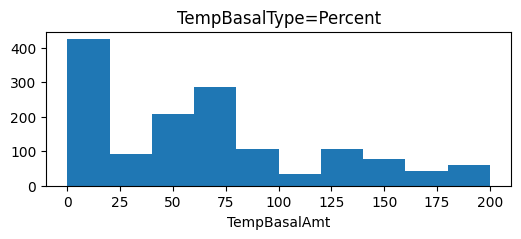

In [28]:
display(df_insulin.loc[df_insulin.TempBasalType =="Percent",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))
plt.figure(figsize=(6,2)); plt.xlabel("TempBasalAmt"); plt.title("TempBasalType=Percent")
plt.hist(df_insulin.loc[df_insulin.TempBasalType =="Percent",'TempBasalAmt']);

,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
58519,2019-06-24 11:47:55,NaN,0.1,Rate,0:01:00
498999,2019-05-17 08:04:58,NaN,1.6,Rate,0:49:00
500045,2019-05-06 11:44:36,NaN,1.3,Rate,1:30:00


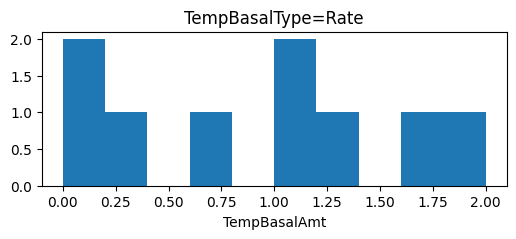

In [30]:
display(df_insulin.loc[df_insulin.TempBasalType =="Rate",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))
plt.figure(figsize=(6,2)); plt.xlabel("TempBasalAmt"); plt.title("TempBasalType=Rate")
plt.hist(df_insulin.loc[df_insulin.TempBasalType =="Rate",'TempBasalAmt']);

<div class="alert alert-block alert-info">TempBasalAmt contains a percentage value if TempBasalType=='Percent' or a rate U/h if TempBasalType=='Rate'. </div>

<div class="alert alert-block alert-info"> The maximum basal temp basal rate programmed using the "Rate" feature only reached 2U/h. While higher temp basal rates can be programmed, only 9 such event mean that this feature was only used by a few users.</div>

<div class="alert alert-block alert-warning">
<b>Interpreting Temp Basal of 100 Percent:</b> The manual notices that *The percentage used is based on the largest basal rate scheduled during the temp basal rate duration*, a value of 100 still changes the basl rate to the highest standard basal rate that would occur within the duration of the temp basal rate. 
</div>

### Are temp basal rates reflected in the BasalRt?
The TempBasalAmt tells us how much the standard rate is changed. It is unclear weather these changes are already reflected in the BasalRt. Do figure this out we can check what happens to BasalRt when somebody uses a fixed basal rate or 0%.

In [157]:
def parse_duration(duration_str):
  """
  Parses a duration string in format "HH:MM:SS" to timedelta.

  Args:
      duration_str: The duration string to parse.

  Returns:
      A timedelta object representing the parsed duration.
  """
  hours, minutes, seconds = map(int, duration_str.split(":"))
  return timedelta(hours=hours, minutes=minutes, seconds=seconds)
    
def drawInsulinEvents(df):
    f = plt.figure(figsize=(15,3))
    ax = f.gca();
    twinax=ax.twinx()

    plt.title(f"Patient {df.PtID.iloc[0]}")

    temp = df.copy()
    temp = temp.sort_values("DateTime")
    boluses = temp.dropna(subset=['BolusDeliv'],axis=0)
    basalRates = temp.dropna(subset=['BasalRt'],axis=0)
    tmpBasals = temp.dropna(subset=['TempBasalAmt'],axis=0)

    #boluses
    if len(boluses) > 0:
        ax.bar(boluses.DateTime, boluses.BolusDeliv, width=timedelta(minutes=15), label='boluses')
        
    #basal rates
    if len(basalRates) > 0:
        ax.stem(basalRates.DateTime, basalRates.BasalRt, label='basal rates',markerfmt='None',linefmt='r-')
        ax.stairs(basalRates.BasalRt.iloc[:-1],basalRates.DateTime, label='basal rates',color='red',fill=True,alpha=0.2,)
    
    
    if len(tmpBasals) > 0:
        #temp basal rates
        
        #ax.stem(tmpBasals.DateTime, tmpBasals.TempBasalAmt, label='temp basal amount',markerfmt='None',linefmt='r-')
        #ax.stairs(basalRates.BasalRt.iloc[:-1],basalRates.DateTime, label='basal rates',color='red',fill=True,alpha=0.2,)
        plt.bar(tmpBasals.DateTime, tmpBasals.TempBasalAmt.apply(lambda x: 5 if x==0 else x), 
                width=tmpBasals.TempBasalDur.apply(parse_duration), 
                align='edge', label='temp basal amount',color='yellow');
        
    ax.set_ylim([0,10]);
    ax.legend(loc='upper left')
    twinax.set_ylim([0,250])
    twinax.legend(loc="upper right")
    return ax

## Investigate when temp basal was set to 0

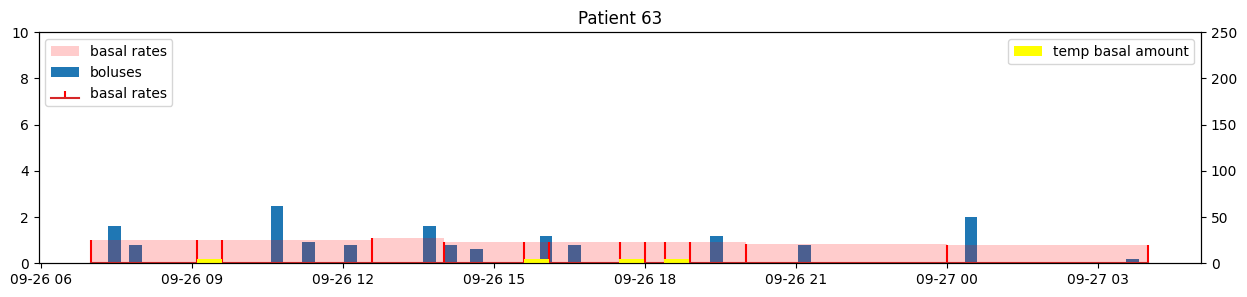

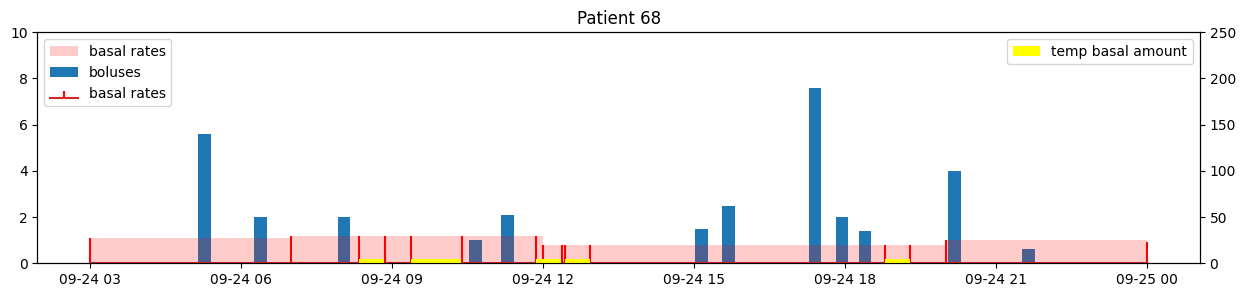

In [162]:
def selectRegionAroundEvent(df, patient_id, date_time, hours):
    sub_frame = df.loc[(df.PtID==patient_id) & (df.DateTime>date_time-timedelta(hours=hours)) & (df.DateTime<date_time+timedelta(hours=hours))]
    return sub_frame

#we select a random temp basal event with temp basal set to zero and some data around it
zeroRateEvents = df_insulin.loc[df_insulin.TempBasalAmt==0]
random_index = random.choice(zeroRateEvents.index)
subFrame = selectRegionAroundEvent(df_insulin, 
                                   zeroRateEvents.loc[random_index,'PtID'], 
                                   zeroRateEvents.loc[random_index,'DateTime'], 12)
drawInsulinEvents(subFrame)

#same just with a fixed event (for reproducibility)
subFrame = selectRegionAroundEvent(df_insulin, 
                                   zeroRateEvents.loc[1044474,'PtID'], 
                                   zeroRateEvents.loc[1044474,'DateTime'], 12)
drawInsulinEvents(subFrame);

<div class="alert alert-block alert-warning">
<b>Temp Basal Not Reflected in Basal Rate:</b> As we can see, the temporary Basal Events do not affect the basal rate. Therefore, we need to do post-processing to obtain the real basal rate
</div>

No handles with labels found to put in legend.


<AxesSubplot:>

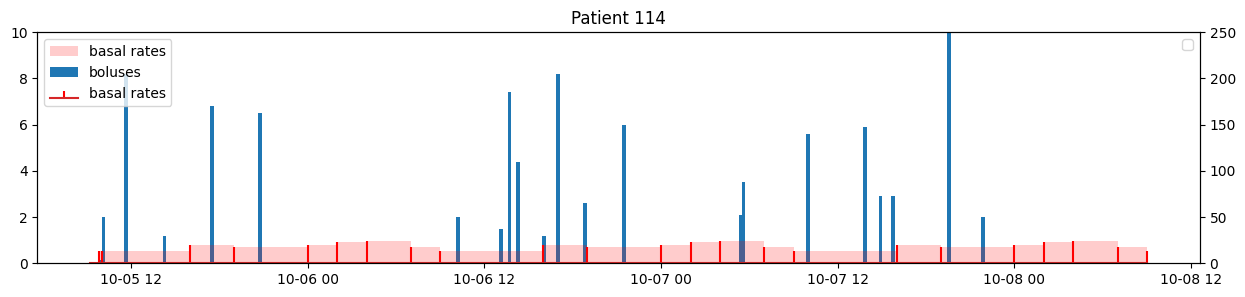

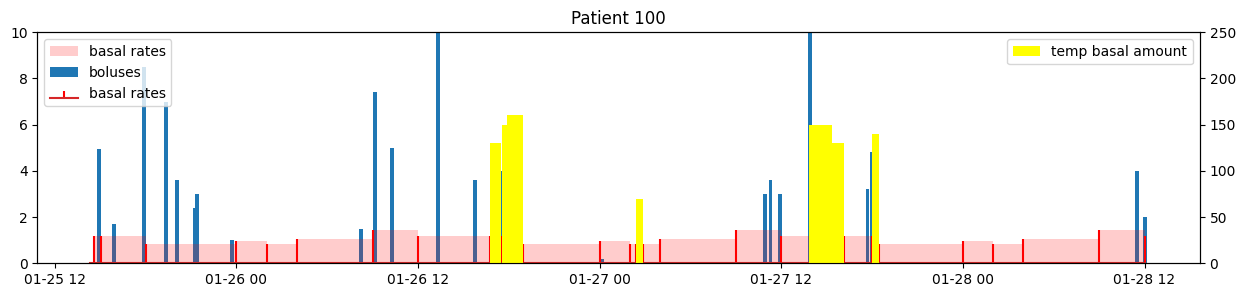

In [169]:
def first_days_random_patient(df,days=3, patient_id=None):
    if not patient_id:
        patient_id = random.choice(df_insulin.PtID.unique())
    temp = df_insulin.loc[df_insulin.PtID==patient_id]
    return temp.loc[temp.DateTime<temp.DateTime.min()+timedelta(hours=72)]

patient_id = random.choice(df_insulin.PtID.unique())
sub_frame = first_days_random_patient(df_insulin, days=5, patient_id=patient_id)
drawInsulinEvents(sub_frame)

#for reproducibility for a fixed patient
sub_frame = first_days_random_patient(df_insulin, days=5, patient_id=100)
drawInsulinEvents(sub_frame)